# SQLAlchemy, Sqlite, and Dates

## Setup

In [14]:
import matplotlib
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [15]:
import pandas as pd

In [16]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [17]:
engine = create_engine("sqlite:///Resources/dow.sqlite", echo=False)

In [18]:
engine.execute('SELECT * FROM dow LIMIT 5').fetchall()

[(1, 1, 'AA', '2011-01-07', 15.82, 16.72, 15.78, 16.42, 239655616, None),
 (2, 1, 'AA', '2011-01-14', 16.71, 16.71, 15.64, 15.97, 242963398, None),
 (3, 1, 'AA', '2011-01-21', 16.19, 16.38, 15.6, 15.79, 138428495, None),
 (4, 1, 'AA', '2011-01-28', 15.87, 16.63, 15.82, 16.13, 151379173, None),
 (5, 1, 'AA', '2011-02-04', 16.18, 17.39, 16.18, 17.14, 154387761, None)]

In [19]:
inspector = inspect(engine)
columns = inspector.get_columns('dow')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
quarter INTEGER
stock TEXT
date TEXT
open_price FLOAT
high_price FLOAT
low_price FLOAT
close_price FLOAT
volume INTEGER
percent_change FLOAT


## Reflect and query dates

In [20]:
# Reflect Database into ORM class
Base = automap_base()
Base.prepare(engine, reflect=True)
Dow = Base.classes.dow

In [21]:
session = Session(engine)

## Analysis

Analyze the Average prices (open, high, low, close) for all stocks in the Month of May

In [25]:
# Query for the stock and average prices (open, high, low, close) 
# for all stock in the month of May
# Sort the result by stock name

sel = [Dow.stock, 
       func.avg(Dow.open_price), 
       func.avg(Dow.high_price), 
       func.avg(Dow.low_price), 
       func.avg(Dow.close_price)]

# YOUR CODE HERE
may_avg = (
       session.query(*sel)
       .filter(func.strftime("%m", Dow.date)=="05")
       .group_by(Dow.stock)
       .order_by(Dow.stock)
       .statement
)
print(may_avg)

SELECT dow.stock, avg(dow.open_price) AS avg_1, avg(dow.high_price) AS avg_2, avg(dow.low_price) AS avg_3, avg(dow.close_price) AS avg_4 
FROM dow 
WHERE strftime(:strftime_1, dow.date) = :strftime_2 GROUP BY dow.stock ORDER BY dow.stock


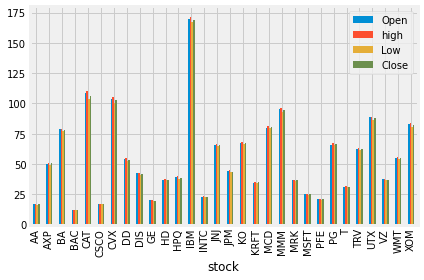

In [30]:
# Add the May averages into a DataFrame
df = pd.read_sql(may_avg, session.bind)
df.set_index("stock", inplace=True)
df.plot.bar()
plt.legend(["Open", "high", "Low", "Close"])
plt.tight_layout()
plt.show()

### Bonus
Calculate the high-low peak-to-peak (PTP) values for `IBM` stock after `2011-05-31`. 
* Note: high-low PTP is calculated using `high_price` - `low_price`
* Use a DateTime.date object in the query filter
* Use a list comprehension or numpy's ravel method to unpack the query's list of tuples into a list of PTP values.
* Use matplotlib to plot the PTP values as a boxplot

In [34]:
# Design a query to calculate the PTP for stock `IBM` after May, 2011
# YOUR CODE HERE
import datetime as dt
import numpy as np

date = dt.datetime(2011, 5, 31)
res = (
    session.query(Dow.high_price - Dow.low_price)
    .filter(Dow.date > date)
    .filter(Dow.stock == "IBM")
    .all()
)
ptps = list(np.ravel(res))
ptps

[5.759999999999991, 3.0900000000000034, 3.579999999999984, 3.219999999999999]

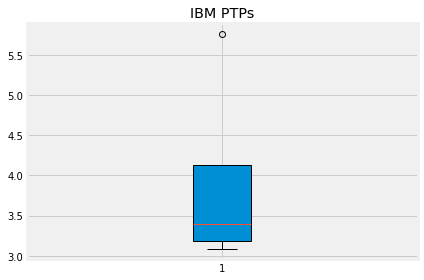

In [38]:
# Load the query into a dataframe, set the index to the date, and plot the ptps
# YOUR CODE HERE
fig, ax = plt.subplots()
x = range(len(ptps))
y = ptps
ax.boxplot(y, patch_artist=True)
ax.set_title("IBM PTPs")
fig.tight_layout()
plt.show()